# Gesture Recognition

**Problem Statement** - Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. In this group project, I am going to build 3D Conv and CNN-RNN models that will be able to predict the 5 gestures correctly.

# Import Libraries

In [4]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import pickle
import matplotlib.pyplot as plt

In [5]:
model_name='models/3D Convs'
if not os.path.exists(model_name):
    os.makedirs(model_name)

I set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, I read the folder names for training and validation. I also set the `batch_size` & `num_epochs` here.

In [7]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 16 #experiment with the batch size

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


# Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, I am going to preprocess(resize & normalize) the images as we have images of 2 different dimensions as well as create a batch of video frames. I set `img_idx`, `y`,`z`.

In [9]:
img_idx = range(0,30,1) #create a list of image numbers you want to use for a particular video. I am using all the frames
x=len(img_idx) # x is the number of images in each video
y=128 # (y,z) is the final size of the input images 
z=128

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image=resize(image,(y,z))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255. #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255. #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255. #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        batch_data = np.zeros((len(folder_list)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((len(folder_list)%batch_size,5)) # batch_labels is the one hot representation of the output    
        for folder in range(len(folder_list)%batch_size):
          imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
          for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
              image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
              
              #crop the images and resize them. Note that the images are of 2 different shape 
              #and the conv3D will throw error if the inputs in a batch have different shapes
              
              image=resize(image,(y,z))
              batch_data[folder,idx,:,:,0] = image[:,:,0]/255. #normalise and feed in the image
              batch_data[folder,idx,:,:,1] = image[:,:,1]/255. #normalise and feed in the image
              batch_data[folder,idx,:,:,2] = image[:,:,2]/255. #normalise and feed in the image
                    
              
          batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [10]:
# Plot history function

def plotHistory(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# 3D Convs

In this part I make models using `Conv3D` and `MaxPooling3D` layers that Keras provides. 3D convolutions are a natural extension to the 2D convolutions. Just like in 2D conv, you move the filter in two directions (x and y), in 3D conv, you move the filter in three directions (x, y and z). In this case, the input to a 3D conv is a video (which is a sequence of 30 RGB images). 

**Because of long training times and lots of parameters I decided to run experiments with less amount of data (train - 200 videos & val - 50 videos) and 10 epochs.**

## Experiment 1

Start with large batch size and all frames

`batch_size = 64`

`30 frames`

`1 Conv3D layer`

--> Failed to allocate memory 

In [8]:
# Define Parameters

batch_size = 64
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-1'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

2022-07-12 09:51:15.440909: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-12 09:51:15.440968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 150, 150, 64)  5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 75, 75, 64)   0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5400000)           0         
                                                                 
 dense (Dense)               (None, 5)                 27000005  
                                                                 
Total params: 27,005,253
Trainable params: 27,005,253
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/10


2022-07-12 09:51:32.234345: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2022-07-12 09:51:32.320846: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


## Experiment 2

Reduce number of frames to half

`batch_size = 64`

`15 frames`

`1 Conv3D layer`

--> ResourceExhaustedError

In [8]:
# Define Parameters

batch_size = 64
img_idx = range(0,30,2)
x=len(img_idx)
y=150
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-2'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 150, 150, 64)  5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 75, 75, 64)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2520000)           0         
                                                                 
 dense (Dense)               (None, 5)                 12600005  
                                                                 
Total params: 12,605,253
Trainable params: 12,605,253
Non-trainable params: 0
_________________________________________________________________
None


2022-07-12 09:52:43.635918: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-12 09:52:43.635978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [10]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/10


2022-07-12 09:52:52.827674: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2022-07-12 09:52:52.910494: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-07-12 09:53:04.811388: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.15GiB (rounded to 5529600000)requested by op sequential/max_pooling3d/MaxPool3D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-12 09:53:04.811483: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-07-12 09:53:04.811523: I tensorflow/core/common_runtime/bfc_

ResourceExhaustedError:  OOM when allocating tensor with shape[64,64,15,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/max_pooling3d/MaxPool3D
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_618]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/max_pooling3d/MaxPool3D:
In[0] sequential/conv3d/Relu (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:4867)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_1350/104263844.py", line 4, in <module>
>>>     history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py", line 699, in call
>>>     outputs = self.pool_function(
>>> 

## Experiment 3

`batch_size = 32`

`30 frames`

`1 Conv3D layer`

--> ResourceExhaustedError

In [11]:
# Define Parameters

batch_size = 32
img_idx = range(0,30,1)
x=len(img_idx)
y=150 
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-3'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           (None, 30, 150, 150, 64)  5248      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 15, 75, 75, 64)   0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5400000)           0         
                                                                 
 dense_1 (Dense)             (None, 5)                 27000005  
                                                                 
Total params: 27,005,253
Trainable params: 27,005,253
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10


2022-07-12 09:56:17.492900: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.15GiB (rounded to 5529600000)requested by op sequential_1/max_pooling3d_1/MaxPool3D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-12 09:56:17.492998: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-07-12 09:56:17.493039: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 51, Chunks in use: 50. 12.8KiB allocated for chunks. 12.5KiB in use in bin. 2.1KiB client-requested in use in bin.
2022-07-12 09:56:17.493062: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 768B allocated for chunks. 768B in use in bin. 640B client-requested in use in bin.
2022-07-12

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,30,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/max_pooling3d_1/MaxPool3D
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1235]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/max_pooling3d_1/MaxPool3D:
In[0] sequential_1/conv3d_1/Relu (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:4867)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_1350/104263844.py", line 4, in <module>
>>>     history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py", line 699, in call
>>>     outputs = self.pool_function(
>>> 

## Experiment 4

`batch_size = 32`

`15 frames`

`1 Conv3D layer`

--> ResourceExhaustedError

In [14]:
# Define Parameters

batch_size = 32
img_idx = range(0,30,2)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-4'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 15, 150, 150, 64)  5248      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 7, 75, 75, 64)    0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2520000)           0         
                                                                 
 dense_2 (Dense)             (None, 5)                 12600005  
                                                                 
Total params: 12,605,253
Trainable params: 12,605,253
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10


2022-07-12 09:57:56.015572: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.57GiB (rounded to 2764800000)requested by op gradient_tape/sequential_2/max_pooling3d_2/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-12 09:57:56.015682: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-07-12 09:57:56.015729: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 68, Chunks in use: 67. 17.0KiB allocated for chunks. 16.8KiB in use in bin. 2.7KiB client-requested in use in bin.
2022-07-12 09:57:56.015755: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in 

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,15,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_2/max_pooling3d_2/MaxPool3D/MaxPool3DGrad
 (defined at /usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1852]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential_2/max_pooling3d_2/MaxPool3D/MaxPool3DGrad:
In[0] sequential_2/conv3d_2/Relu (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:4867)	
In[1] sequential_2/max_pooling3d_2/MaxPool3D (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)	
In[2] gradient_tape/sequential_2/flatten_2/Reshape:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_1350/104263844.py", line 4, in <module>
>>>     history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

7:56.018153: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 6 Chunks of size 20736 totalling 121.5KiB
2022-07-12 09:57:56.018172: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 38144 totalling 37.2KiB
2022-07-12 09:57:56.018192: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 39936 totalling 39.0KiB
2022-07-12 09:57:56.018211: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 40448 totalling 39.5KiB
2022-07-12 09:57:56.018230: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 3 Chunks of size 50400000 totalling 144.20MiB
2022-07-12 09:57:56.018249: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 2 Chunks of size 67108864 totalling 128.00MiB
2022-07-12 09:57:56.018270: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 83817728 totalling 79.93MiB
2022-07-12 09:57:56.018290: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 2 Chunks of size 108000000 totalling 205.

## Experiment 5

`batch_size = 32`

`15 frames`

`y=128`

`z=128`

`1 Conv3D layer`

--> Model trained successfully

--> But it is underfitting

In [18]:
# Define Parameters

batch_size = 32
img_idx = range(0,30,2)
x=len(img_idx)
y=128
z=128
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-5'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 128, 128, 64)  5248      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 64, 64, 64)    0         
 3D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1835008)           0         
                                                                 
 dense_3 (Dense)             (None, 5)                 9175045   
                                                                 
Total params: 9,180,293
Trainable params: 9,180,293
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 255.9777 - categorical_accuracy: 0.1600Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_categorical_accuracy improved from -inf to 0.38000, saving model to models/exp-5/model-01-0.16-0.38.h5
7/7 [==============================] - 30s 5s/step - loss: 255.9777 - categorical_accuracy: 0.1600 - val_loss: 1.5416 - val_categorical_accuracy: 0.3800 - lr: 0.0100
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 1.4596 - categorical_accuracy: 0.3050
Epoch 00002: val_categorical_accuracy did not improve from 0.38000
7/7 [==============================] - 27s 5s/step - loss: 1.4596 - categorical_accuracy: 0.3050 - val_loss: 1.4385 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 1.3803 - categorical_accuracy: 0.4200
Epoch 00003: val_categorical_accuracy

2022-07-12 10:05:16.855542: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://27bc24dd-1d79-4bb1-b7db-a020ad0d8a79/assets


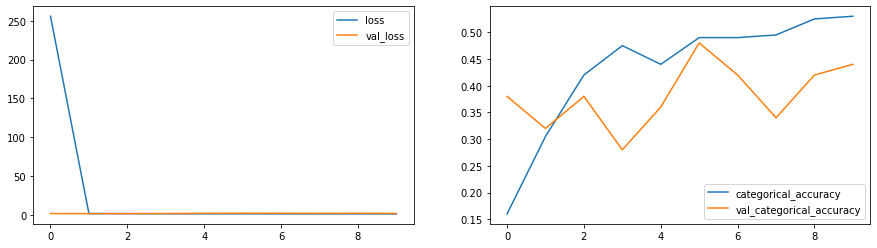

In [21]:
plotHistory(history)

## Experiment 6

`Add more layers`

`4 Conv3D and 2 Dense layers `

--> Cannot add 4 Conv3D layers with 15 frames

In [23]:
# Define Parameters

batch_size = 32
img_idx = range(0,30,2)
x=len(img_idx)
y=128  
z=128
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-6'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [24]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

ValueError: Exception encountered when calling layer "max_pooling3d_7" (type MaxPooling3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling3d_7/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1]](Placeholder)' with input shapes: [?,1,16,16,128].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 16, 16, 128), dtype=float32)

## Experiment 7

Add more layers

`4 Conv3D and 2 Dense layers `

`batch_size = 32`

`30 frames`

--> ResourceExhaustedError

In [25]:
# Define Parameters

batch_size = 32
img_idx = range(0,30,1)
x=len(img_idx)
y=128  
z=128
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-7'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [26]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 128, 128, 64)  5248      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 64, 64, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 64, 64, 32)    55328     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 32, 32, 32)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 32, 32, 64)     55360     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 16, 16, 64)   

In [27]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10


2022-07-12 10:15:56.163846: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.75GiB (rounded to 4026531840)requested by op gradient_tape/sequential_5/max_pooling3d_8/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-12 10:15:56.163956: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-07-12 10:15:56.163994: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 97, Chunks in use: 96. 24.2KiB allocated for chunks. 24.0KiB in use in bin. 5.3KiB client-requested in use in bin.
2022-07-12 10:15:56.164021: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 7, Chunks in use: 7. 3.8KiB allocated for chunks. 3.8KiB in use in bin. 3.5KiB client-r

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,30,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_5/max_pooling3d_8/MaxPool3D/MaxPool3DGrad
 (defined at /usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5066]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential_5/max_pooling3d_8/MaxPool3D/MaxPool3DGrad:
In[0] sequential_5/conv3d_8/Relu (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:4867)	
In[1] sequential_5/max_pooling3d_8/MaxPool3D (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)	
In[2] gradient_tape/sequential_5/conv3d_9/Conv3D/Conv3DBackpropInputV2:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_1350/104263844.py", line 4, in <module>
>>>     history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

In [ ]:
plotHistory(history)

## Experiment 8

`4 Conv3D and 2 Dense layers `

`batch_size = 16`

`30 frames`

--> Model trained successfully

--> Underfitted

In [28]:
# Define Parameters

batch_size = 16
img_idx = range(0,30,1)
x=len(img_idx)
y=128  
z=128
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-8'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [29]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (3, 3, 3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 128, 128, 64)  5248      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 64, 64, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 64, 64, 32)    55328     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 7, 32, 32, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 7, 32, 32, 64)     55360     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 3, 16, 16, 64)   

In [30]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 47.6695 - categorical_accuracy: 0.1800Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.20000, saving model to models/exp-8/model-01-0.18-0.20.h5
13/13 [==============================] - 63s 5s/step - loss: 47.6695 - categorical_accuracy: 0.1800 - val_loss: 1.6199 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.6353 - categorical_accuracy: 0.2400
Epoch 00002: val_categorical_accuracy improved from 0.20000 to 0.28000, saving model to models/exp-8/model-02-0.24-0.28.h5
13/13 [==============================] - 62s 5s/step - loss: 1.6353 - categorical_accuracy: 0.2400 - val_loss: 1.6013 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.6029 - ca

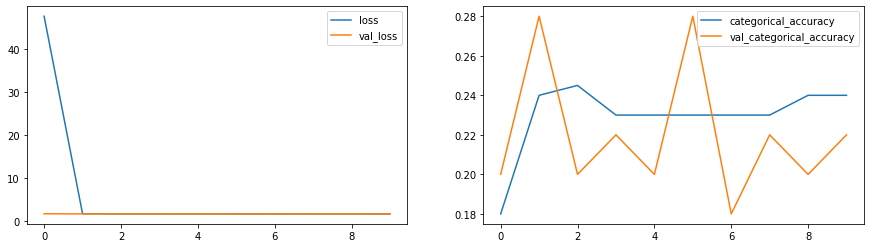

In [31]:
plotHistory(history)

## Experiment 9

`Add BatchNormalization and Dropout layers`

--> Model trained successfully

--> Overfitted

In [34]:
# Define Parameters

batch_size = 16
img_idx = range(0,30,1)
x=len(img_idx)
y=128  
z=128
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/3D Convs/exp-9'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [35]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, (3, 3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (3, 3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 128, 128, 64)  5248      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 128, 128, 64)  256      
 hNormalization)                                                 
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 64, 64, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 64, 64, 32)    55328     
                                                                 
 batch_normalization_7 (Batc  (None, 15, 64, 64, 32)   128       
 hNormalization)                                                 
                                                      

In [36]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 2.1550 - categorical_accuracy: 0.2800Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.20000, saving model to models/exp-9/model-01-0.28-0.20.h5
13/13 [==============================] - 61s 5s/step - loss: 2.1550 - categorical_accuracy: 0.2800 - val_loss: 4031.2664 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.5847 - categorical_accuracy: 0.4050
Epoch 00002: val_categorical_accuracy improved from 0.20000 to 0.22000, saving model to models/exp-9/model-02-0.41-0.22.h5
13/13 [==============================] - 65s 5s/step - loss: 1.5847 - categorical_accuracy: 0.4050 - val_loss: 921.4398 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.1174 -

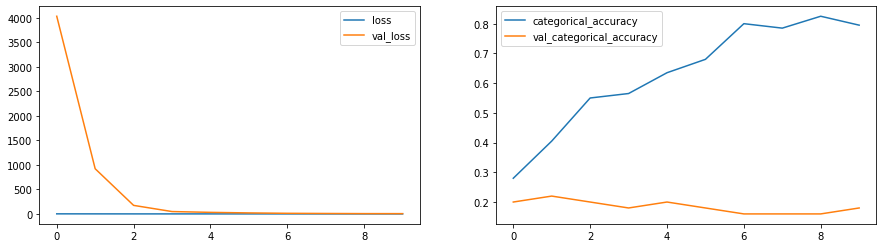

In [37]:
plotHistory(history)

## Experiment 10

`Train on all data`

`num_epochs=25`

--> Model trained successfully

In [38]:
# Define Parameters

batch_size = 16
img_idx = range(0,30,1)
x=len(img_idx)
y=128  
z=128
num_epochs=25
num_train_sequences=663
num_val_sequences=100
lr=0.01
model_name = 'models/3D Convs/exp-10'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [39]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D

#write your model here

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu',input_shape=(len(img_idx),y,z,3),padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, (3, 3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (3, 3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 128, 128, 64)  5248      
                                                                 
 batch_normalization_12 (Bat  (None, 30, 128, 128, 64)  256      
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 64, 64, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 64, 64, 32)    55328     
                                                                 
 batch_normalization_13 (Bat  (None, 15, 64, 64, 32)   128       
 chNormalization)                                                
                                                      

In [40]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.5834 - categorical_accuracy: 0.4178Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to models/exp-10/model-01-0.42-0.23.h5
42/42 [==============================] - 186s 5s/step - loss: 1.5834 - categorical_accuracy: 0.4178 - val_loss: 225.7710 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.0683 - categorical_accuracy: 0.5732
Epoch 00002: val_categorical_accuracy did not improve from 0.23000
42/42 [==============================] - 187s 5s/step - loss: 1.0683 - categorical_accuracy: 0.5732 - val_loss: 41.0553 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 0.9321 - categorical_accuracy: 0.6214
Epoch 00003: val_categori

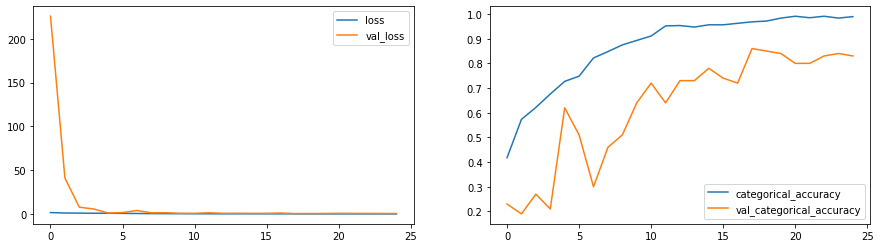

In [41]:
plotHistory(history)

# CNN-RNN Stack

I this part I make models using CNN (pre-trained) & RNN layers. In the standard CNN + RNN architecture we pass the images of a video through a CNN which extracts a feature vector for each image, and then pass the sequence of these feature vectors through an RNN.

**Because of long training times and lots of parameters I decided to run experiments with less amount of data (train - 200 videos & val - 50 videos) and 10 epochs.**

## Experiment 1

`InceptionV3`

`LSTM`

`batch_size = 128`

`30 frames`

`y=150`

`z=150`

--> Overfitted 

In [20]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/CNN-RNN/exp-1'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionV3

#write your model here

base_model = InceptionV3(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dense(64))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 30, 3, 3, 2048)   21802784  
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 128)               1114624   
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                      

In [22]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 1.8763 - categorical_accuracy: 0.2000 Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.20000, saving model to models/CNN-RNN/exp-1/model-01-0.20-0.20.h5
2/2 [==============================] - 63s 52s/step - loss: 1.8763 - categorical_accuracy: 0.2000 - val_loss: 2.0965 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 1.8349 - categorical_accuracy: 0.2500
Epoch 00002: val_categorical_accuracy improved from 0.20000 to 0.28000, saving model to models/CNN-RNN/exp-1/model-02-0.25-0.28.h5
2/2 [==============================] - 51s 47s/step - loss: 1.8349 - categorical_accuracy: 0.2500 - val_loss: 1.6360 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 1.

2022-07-12 13:52:35.337312: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://31edc2a2-82a7-4149-882f-0c17bd45a0e6/assets


INFO:tensorflow:Assets written to: ram://31edc2a2-82a7-4149-882f-0c17bd45a0e6/assets


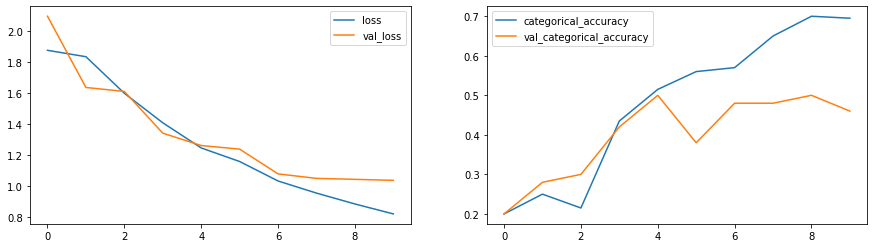

In [23]:
plotHistory(history)

## Experiment 2

`Add Dropout and BatchNormalization layers`

`dropout rate = 0.25`

--> Overfitted

In [10]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/CNN-RNN/exp-2'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionV3

#write your model here

base_model = InceptionV3(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.25)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.25)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.25)))
model.add(LSTM(128,dropout=0.25))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 30, 3, 3, 2048)   21802784  
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 3, 3, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 3, 3, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 30, 2048)        

In [12]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/10


2022-07-13 09:51:27.359560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2022-07-13 09:51:29.059374: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-07-13 09:51:29.635250: W tensorflow/core/common_runtime/bfc_allocator.cc:344] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


2/2 [==============================] - ETA: 0s - loss: 2.1081 - categorical_accuracy: 0.2950 Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.32000, saving model to models/CNN-RNN/exp-2/model-01-0.29-0.32.h5
2/2 [==============================] - 69s 50s/step - loss: 2.1081 - categorical_accuracy: 0.2950 - val_loss: 1.9272 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.6682 - categorical_accuracy: 0.7600
Epoch 00002: val_categorical_accuracy improved from 0.32000 to 0.40000, saving model to models/CNN-RNN/exp-2/model-02-0.76-0.40.h5
2/2 [==============================] - 50s 46s/step - loss: 0.6682 - categorical_accuracy: 0.7600 - val_loss: 1.6380 - val_categorical_accuracy: 0.4000 - lr: 0.0100
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.3368 - categorical_accuracy: 0.9050
Epoch 00003: val_categorical_accuracy did n

2022-07-13 10:01:06.949636: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://f30c14fe-7618-4279-8508-cdca2de7ab9e/assets


INFO:tensorflow:Assets written to: ram://f30c14fe-7618-4279-8508-cdca2de7ab9e/assets


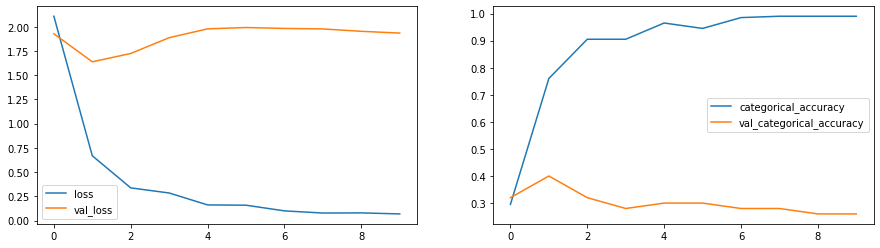

In [13]:
plotHistory(history)

## Experiment 3

Medium dropout rate

`dropout rate = 0.5`

--> Reduced overfitting

In [14]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/CNN-RNN/exp-3'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionV3

#write your model here

base_model = InceptionV3(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(LSTM(128,dropout=0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 30, 3, 3, 2048)   21802784  
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 3, 3, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 3, 3, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 30, 2048)        

In [16]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 2.3406 - categorical_accuracy: 0.2350Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.36000, saving model to models/CNN-RNN/exp-3/model-01-0.23-0.36.h5
2/2 [==============================] - 63s 53s/step - loss: 2.3406 - categorical_accuracy: 0.2350 - val_loss: 1.4087 - val_categorical_accuracy: 0.3600 - lr: 0.0100
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 1.8288 - categorical_accuracy: 0.3400
Epoch 00002: val_categorical_accuracy improved from 0.36000 to 0.44000, saving model to models/CNN-RNN/exp-3/model-02-0.34-0.44.h5
2/2 [==============================] - 49s 46s/step - loss: 1.8288 - categorical_accuracy: 0.3400 - val_loss: 1.3176 - val_categorical_accuracy: 0.4400 - lr: 0.0100
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 1.4

INFO:tensorflow:Assets written to: ram://2a411d68-6ae5-481a-8d37-a7a925703433/assets


INFO:tensorflow:Assets written to: ram://2a411d68-6ae5-481a-8d37-a7a925703433/assets


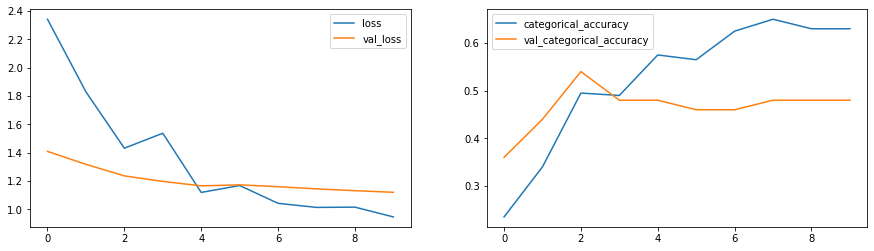

In [17]:
plotHistory(history)

## Experiment 4

High dropout rate

`dropout rate = 0.7`

--> Underfitting

In [18]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/CNN-RNN/exp-4'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionV3

#write your model here

base_model = InceptionV3(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.7)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.7)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(LSTM(128,dropout=0.7))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 30, 3, 3, 2048)   21802784  
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 30, 3, 3, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 30, 3, 3, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 30, 2048)        

In [21]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 3.3237 - categorical_accuracy: 0.1750Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.44000, saving model to models/CNN-RNN/exp-4/model-01-0.17-0.44.h5
2/2 [==============================] - 88s 78s/step - loss: 3.3237 - categorical_accuracy: 0.1750 - val_loss: 1.4486 - val_categorical_accuracy: 0.4400 - lr: 0.0100
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 2.7010 - categorical_accuracy: 0.2000
Epoch 00002: val_categorical_accuracy did not improve from 0.44000
2/2 [==============================] - 51s 50s/step - loss: 2.7010 - categorical_accuracy: 0.2000 - val_loss: 1.4082 - val_categorical_accuracy: 0.3800 - lr: 0.0100
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 2.6448 - categorical_accuracy: 0.2350
Epoch 00003: val_categorical_

INFO:tensorflow:Assets written to: ram://c1cbcc02-e9dd-46ee-ae36-272f1fe939df/assets


INFO:tensorflow:Assets written to: ram://c1cbcc02-e9dd-46ee-ae36-272f1fe939df/assets


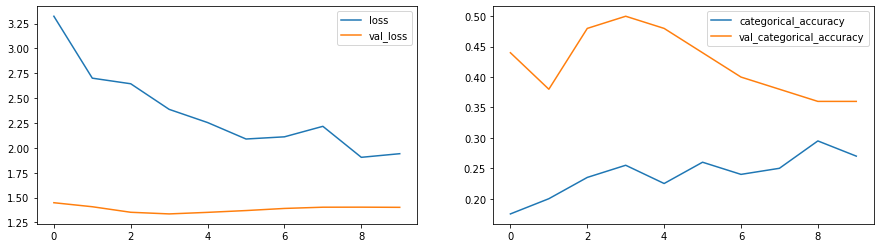

In [22]:
plotHistory(history)

## Experiment 5

High dropout rate

`dropout rate = 0.6`

--> Underfitted

In [23]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/CNN-RNN/exp-5'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [24]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionV3

#write your model here

base_model = InceptionV3(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.6)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.6)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.6)))
model.add(LSTM(128,dropout=0.6))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 30, 3, 3, 2048)   21802784  
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 30, 3, 3, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 30, 3, 3, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 30, 2048)        

In [25]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 3.0744 - categorical_accuracy: 0.1650Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.30000, saving model to models/CNN-RNN/exp-5/model-01-0.17-0.30.h5
2/2 [==============================] - 68s 59s/step - loss: 3.0744 - categorical_accuracy: 0.1650 - val_loss: 1.5390 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 2.3030 - categorical_accuracy: 0.2500
Epoch 00002: val_categorical_accuracy did not improve from 0.30000
2/2 [==============================] - 50s 47s/step - loss: 2.3030 - categorical_accuracy: 0.2500 - val_loss: 1.6030 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 2.0286 - categorical_accuracy: 0.3150
Epoch 00003: val_categorical_

INFO:tensorflow:Assets written to: ram://f7a19459-45bd-49b1-958d-4d0049fff6bf/assets


INFO:tensorflow:Assets written to: ram://f7a19459-45bd-49b1-958d-4d0049fff6bf/assets


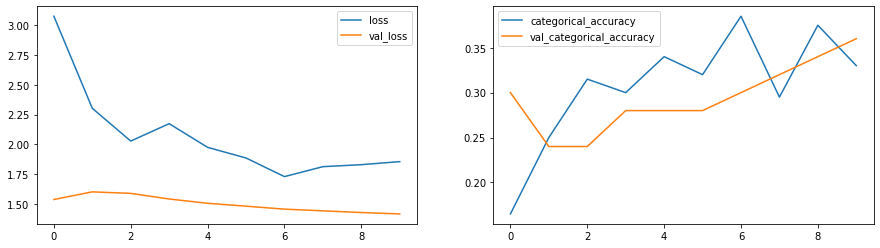

In [26]:
plotHistory(history)

## Experiment 6

`dropout rate = 0.4`

--> Overfitting

In [10]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/CNN-RNN/exp-6'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionV3

#write your model here

base_model = InceptionV3(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.4)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.4)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.4)))
model.add(LSTM(128,dropout=0.4))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 30, 3, 3, 2048)   21802784  
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 3, 3, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 3, 3, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 30, 2048)        

In [12]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/10


2022-07-13 10:48:13.605500: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2022-07-13 10:48:15.705156: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-07-13 10:48:16.282487: W tensorflow/core/common_runtime/bfc_allocator.cc:344] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


2/2 [==============================] - ETA: 0s - loss: 2.2599 - categorical_accuracy: 0.2700 Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.38000, saving model to models/CNN-RNN/exp-6/model-01-0.27-0.38.h5
2/2 [==============================] - 69s 51s/step - loss: 2.2599 - categorical_accuracy: 0.2700 - val_loss: 1.4893 - val_categorical_accuracy: 0.3800 - lr: 0.0100
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 1.0972 - categorical_accuracy: 0.5450
Epoch 00002: val_categorical_accuracy did not improve from 0.38000
2/2 [==============================] - 62s 58s/step - loss: 1.0972 - categorical_accuracy: 0.5450 - val_loss: 1.5106 - val_categorical_accuracy: 0.3600 - lr: 0.0100
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.8672 - categorical_accuracy: 0.6950
Epoch 00003: val_categorical_accuracy did not improve from 0.38000
2/2 [==============================] - 6

2022-07-13 10:58:53.011836: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ec7d1b26-212d-4902-a291-ccc63c149db1/assets


INFO:tensorflow:Assets written to: ram://ec7d1b26-212d-4902-a291-ccc63c149db1/assets


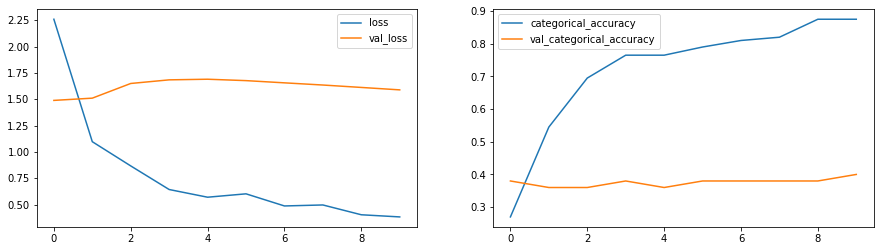

In [13]:
plotHistory(history)

## Experiment 7

`GRU Layer`

`dropout rate = 0.5`

--> Reduced Overfitting

In [14]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/CNN-RNN/exp-7'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionV3

#write your model here

base_model = InceptionV3(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(GRU(128,dropout=0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 30, 3, 3, 2048)   21802784  
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 3, 3, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 3, 3, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 30, 2048)        

In [16]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 2.4278 - categorical_accuracy: 0.2700Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26000, saving model to models/CNN-RNN/exp-7/model-01-0.27-0.26.h5
2/2 [==============================] - 78s 69s/step - loss: 2.4278 - categorical_accuracy: 0.2700 - val_loss: 2.1872 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 1.7771 - categorical_accuracy: 0.4350
Epoch 00002: val_categorical_accuracy improved from 0.26000 to 0.48000, saving model to models/CNN-RNN/exp-7/model-02-0.44-0.48.h5
2/2 [==============================] - 59s 54s/step - loss: 1.7771 - categorical_accuracy: 0.4350 - val_loss: 1.2615 - val_categorical_accuracy: 0.4800 - lr: 0.0100
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 1.3

INFO:tensorflow:Assets written to: ram://e191a8cc-ec18-4319-9f4e-ab47f6b5f22d/assets


INFO:tensorflow:Assets written to: ram://e191a8cc-ec18-4319-9f4e-ab47f6b5f22d/assets


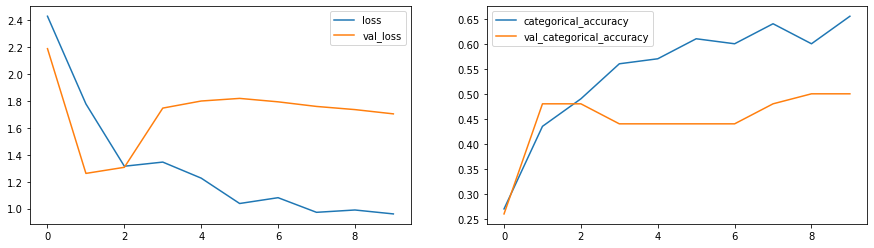

In [17]:
plotHistory(history)

## Experiment 8

`InceptionResNetV2`

`GRU Layer`

--> Reduced Overfitting

In [18]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=10
num_train_sequences=200
num_val_sequences=50
lr=0.01
model_name = 'models/CNN-RNN/exp-8'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionResNetV2

#write your model here

base_model = InceptionResNetV2(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(GRU(128,dropout=0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 30, 3, 3, 1536)   54336736  
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 30, 3, 3, 1536)   6144      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 30, 3, 3, 1536)   0         
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 30, 1536)         0         
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 30, 1536)        

In [20]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 2.7419 - categorical_accuracy: 0.2150 Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.52000, saving model to models/CNN-RNN/exp-8/model-01-0.22-0.52.h5
2/2 [==============================] - 103s 76s/step - loss: 2.7419 - categorical_accuracy: 0.2150 - val_loss: 1.7476 - val_categorical_accuracy: 0.5200 - lr: 0.0100
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 1.5682 - categorical_accuracy: 0.4600
Epoch 00002: val_categorical_accuracy improved from 0.52000 to 0.58000, saving model to models/CNN-RNN/exp-8/model-02-0.46-0.58.h5
2/2 [==============================] - 66s 64s/step - loss: 1.5682 - categorical_accuracy: 0.4600 - val_loss: 1.5392 - val_categorical_accuracy: 0.5800 - lr: 0.0100
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 1

INFO:tensorflow:Assets written to: ram://f303ed94-1d52-4f07-af49-299a8344d87a/assets


INFO:tensorflow:Assets written to: ram://f303ed94-1d52-4f07-af49-299a8344d87a/assets


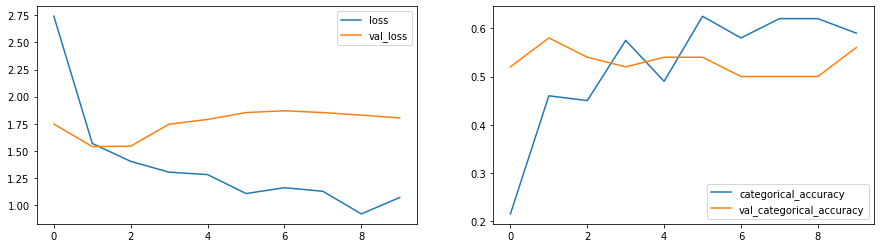

In [21]:
plotHistory(history)

## Experiment 9

`Train on Complete data`

`InceptionResNetV2`

`GRU Layer`

`batch_size = 128`

`30 frames`

`y=150`

`z=150`

`dropout rate = 0.5`

`num_epochs=25`

In [22]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=25
num_train_sequences=663
num_val_sequences=100
lr=0.01
model_name = 'models/CNN-RNN/exp-9'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionResNetV2

#write your model here

base_model = InceptionResNetV2(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(GRU(128,dropout=0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 30, 3, 3, 1536)   54336736  
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 30, 3, 3, 1536)   6144      
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 30, 3, 3, 1536)   0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 30, 1536)         0         
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 30, 1536)        

In [24]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 1.9588 - categorical_accuracy: 0.3560 Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.55000, saving model to models/CNN-RNN/exp-9/model-01-0.36-0.55.h5
6/6 [==============================] - 226s 41s/step - loss: 1.9588 - categorical_accuracy: 0.3560 - val_loss: 1.8730 - val_categorical_accuracy: 0.5500 - lr: 0.0100
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: 1.4191 - categorical_accuracy: 0.4992 
Epoch 00002: val_categorical_accuracy improved from 0.55000 to 0.57000, saving model to models/CNN-RNN/exp-9/model-02-0.50-0.57.h5
6/6 [==============================] - 195s 39s/step - loss: 1.4191 - categorical_accuracy: 0.4992 - val_loss: 1.5455 - val_categorical_accuracy: 0.5700 - lr: 0.0100
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss:

INFO:tensorflow:Assets written to: ram://3002bc62-2d1c-4032-a5cb-3ebab0190dbb/assets


INFO:tensorflow:Assets written to: ram://3002bc62-2d1c-4032-a5cb-3ebab0190dbb/assets


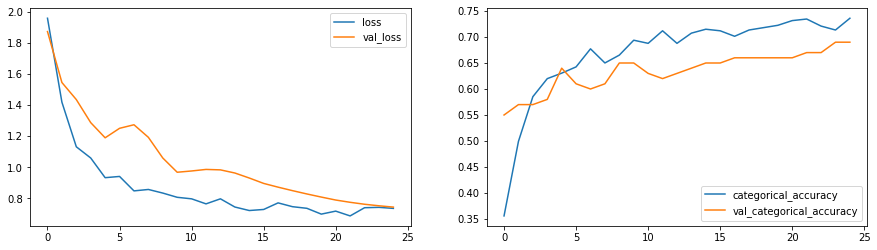

In [25]:
plotHistory(history)

## Experiment 10

`Train on Complete data`

`InceptionResNetV2`

`LSTM Layer`

`batch_size = 128`

`30 frames`

`y=150`

`z=150`

`dropout rate = 0.5`

`num_epochs=25`

In [11]:
# Define Parameters

batch_size = 128
img_idx = range(0,30,1)
x=len(img_idx)
y=150  
z=150
num_epochs=25
num_train_sequences=663
num_val_sequences=100
lr=0.01
model_name = 'models/CNN-RNN/exp-10'
factor=0.5
patience=2

# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc[:num_train_sequences], batch_size)
val_generator = generator(val_path, val_doc[:num_val_sequences], batch_size)

# Define Callbacks

!rm -rf $model_name 

if not os.path.exists(model_name):
    os.makedirs(model_name)
        
filepath = model_name + '/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=factor, patience=patience, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Define Optimizer

optimiser = tf.keras.optimizers.Adam(lr=lr) #write your optimizer

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling2D,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications import InceptionResNetV2

#write your model here

base_model = InceptionResNetV2(weights='imagenet',input_shape=(y,z,3),include_top=False)
base_model.trainable = False
model = Sequential()
model.add(TimeDistributed(base_model,input_shape=(len(img_idx),y,z,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(LSTM(128,dropout=0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Now that I have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

2022-07-13 13:00:07.063031: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-13 13:00:07.063098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22846 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 3, 3, 1536)   54336736  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 3, 3, 1536)   6144      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 3, 3, 1536)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1536)         0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 1536)         6

In [13]:
import warnings
warnings.filterwarnings('ignore')

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save history
with open(model_name+'/history', 'wb') as fh:
    pickle.dump(history, fh, pickle.HIGHEST_PROTOCOL)

Source path =  /home/datasets/Project_data/train ; batch size = 128
Epoch 1/25


2022-07-13 13:01:05.703800: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2022-07-13 13:01:07.359003: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-07-13 13:01:07.936500: W tensorflow/core/common_runtime/bfc_allocator.cc:344] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


6/6 [==============================] - ETA: 0s - loss: 1.9322 - categorical_accuracy: 0.3756 Source path =  /home/datasets/Project_data/val ; batch size = 128

Epoch 00001: val_categorical_accuracy improved from -inf to 0.53000, saving model to models/CNN-RNN/exp-10/model-01-0.38-0.53.h5
6/6 [==============================] - 218s 38s/step - loss: 1.9322 - categorical_accuracy: 0.3756 - val_loss: 1.1643 - val_categorical_accuracy: 0.5300 - lr: 0.0100
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: 1.3845 - categorical_accuracy: 0.5128 
Epoch 00002: val_categorical_accuracy improved from 0.53000 to 0.57000, saving model to models/CNN-RNN/exp-10/model-02-0.51-0.57.h5
6/6 [==============================] - 188s 37s/step - loss: 1.3845 - categorical_accuracy: 0.5128 - val_loss: 1.1861 - val_categorical_accuracy: 0.5700 - lr: 0.0100
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss: 1.1372 - categorical_accuracy: 0.5671 
Epoch 00003: val_categorical_accuracy

2022-07-13 14:19:56.626523: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://3b69bf32-bdad-439b-9912-6f085627660b/assets


INFO:tensorflow:Assets written to: ram://3b69bf32-bdad-439b-9912-6f085627660b/assets


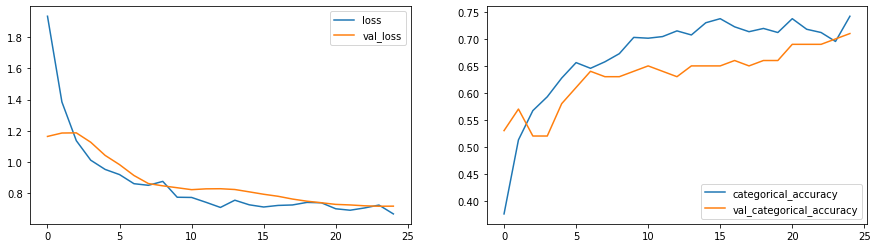

In [14]:
plotHistory(history)